<a href="https://colab.research.google.com/github/chesyaivana/Kel.04_sysrec/blob/main/SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVD

## Section 1: Import Libraries and Load Data


In [ ]:
 import pandas as pd
 import numpy as np
 from sklearn.model_selection import train_test_split
 from sklearn.decomposition import TruncatedSVD
 from sklearn.metrics import mean_squared_error
 import matplotlib.pyplot as plt
 # Load and preprocess the data
 data = pd.read_csv("Tempat-Wisata-Toba-Preprocessing.csv")
 data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
 data['user_id'] = data['user_id'].astype(str)
 data['item_id'] = data['item_id'].astype(str)
 data['rating'] = data['rating'].astype(float)

# Drop irrelevant columns: `address`, `placeID`, `ReviewerId`, `Reviews`
data = data.drop(columns=['Unnamed: 0.1'])
data.dropna(inplace=True)

In [ ]:
data.head()

,Unnamed: 0,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.11909e+20,5.0,bagus
3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.13072e+20,5.0,sangat menyenagkan
4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.06173e+20,5.0,bebas foto dimana aja cuma 2k
6,6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.14239e+20,5.0,amazing pengen kesini lagi
8,8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.04743e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


## Section 2: Data Splitting

In [ ]:
 # Step 1: Split into 85% training+validation and 15% test
 train_val_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
 # Step 2: Define validation size as 17% of train+validation, rounded up
 val_size = int(len(train_val_data) * 0.17) + 1
 # Step 3: Split 85% data into training (about 70% of original) and validation (about 15% of original)
 train_data, val_data = train_test_split(train_val_data, test_size=val_size, random_state=42)
 # Check sizes
 print(f"Train data size: {train_data.shape}")
 print(f"Validation data size: {val_data.shape}")
 print(f"Test data size: {test_data.shape}")

Train data size: (15638, 8)
Validation data size: (3203, 8)
Test data size: (3325, 8)


## Section 3: Create User-Item Matrix

In [ ]:
 def create_user_item_matrix(data, user_col='user_id', item_col='item_id', rating_col='rating'):
  data = data.groupby([user_col, item_col])[rating_col].mean().reset_index()
  return data.pivot(index=user_col, columns=item_col, values=rating_col).fillna(0)
 # Apply the function to create matrices for each split
 train_matrix = create_user_item_matrix(train_data)
 val_matrix = create_user_item_matrix(val_data).reindex(columns=train_matrix.columns, fill_value=0)
 test_matrix = create_user_item_matrix(test_data).reindex(columns=train_matrix.columns,
fill_value=0)

## Section 4: Define RMSE Calculation Function

In [ ]:
 def compute_rmse(true_matrix, approx_matrix):
  return np.sqrt(mean_squared_error(true_matrix.ravel(), approx_matrix.ravel()))

## Section 5: SVD on Training Data

In [ ]:
 # Set up SVD with specified latent factors
 n_factors = 20
 svd = TruncatedSVD(n_components=n_factors, random_state=42)
 U_train = svd.fit_transform(train_matrix)
 Sigma = svd.components_
 # Reconstruct and evaluate on training
 train_approx_matrix = np.dot(U_train, Sigma)
 train_rmse = compute_rmse(train_matrix.values, train_approx_matrix)
 print(f"Training RMSE: {train_rmse:.4f}")

Training RMSE: 0.3680


## Section 6: Project Validation and Test Matrices

In [ ]:
 # Project validation matrix onto the latent space and calculate RMSE
 U_val = np.dot(val_matrix.values, Sigma.T)
 val_approx_matrix = np.dot(U_val, Sigma)
 val_rmse = compute_rmse(val_matrix.values, val_approx_matrix)
 print(f"Validation RMSE: {val_rmse:.4f}")
 # Project test matrix onto the latent space and calculate RMSE
 U_test = np.dot(test_matrix.values, Sigma.T)
 test_approx_matrix = np.dot(U_test, Sigma)
 test_rmse = compute_rmse(test_matrix.values, test_approx_matrix)
 print(f"Test RMSE: {test_rmse:.4f}")

Validation RMSE: 0.3046
Test RMSE: 0.3026


## Section 7: Experiment with Different Numbers of Latent Factors (with Visualization)

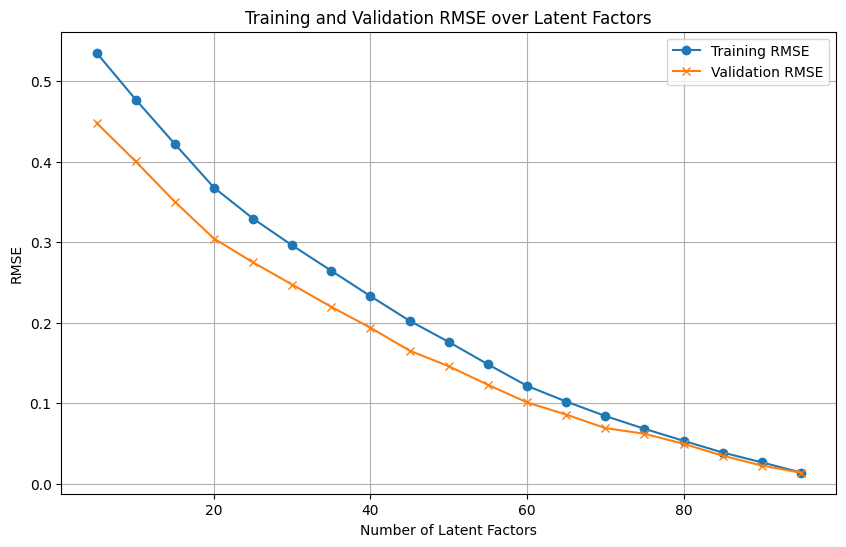

Optimal Number of Latent Factors: 95


In [ ]:
# Dapatkan jumlah kolom pada matriks training
max_factors = train_matrix.shape[1]  # Jumlah kolom dalam train_matrix

# Perbaiki range untuk faktor laten
factors_range = range(5, min(101, max_factors + 1), 5)

train_errors, val_errors = [], []

for n_factors in factors_range:
    # Apply SVD
    svd = TruncatedSVD(n_components=n_factors, random_state=42)
    U_train = svd.fit_transform(train_matrix)
    Sigma = svd.components_

    # Reconstruct training matrix
    train_approx_matrix = np.dot(U_train, Sigma)
    train_rmse = compute_rmse(train_matrix.values, train_approx_matrix)
    train_errors.append(train_rmse)

    # Reconstruct validation matrix
    U_val = np.dot(val_matrix.values, Sigma.T)
    val_approx_matrix = np.dot(U_val, Sigma)
    val_rmse = compute_rmse(val_matrix.values, val_approx_matrix)
    val_errors.append(val_rmse)

# Plot the RMSE for training and validation
plt.figure(figsize=(10, 6))
plt.plot(factors_range, train_errors, label="Training RMSE", marker='o')
plt.plot(factors_range, val_errors, label="Validation RMSE", marker='x')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.title("Training and Validation RMSE over Latent Factors")
plt.grid()
plt.show()

# Pilih jumlah latent factors optimal berdasarkan error minimum pada validation
optimal_factors = factors_range[val_errors.index(min(val_errors))]
print(f"Optimal Number of Latent Factors: {optimal_factors}")


## Section 8: Final Model Evaluation on Test Set

In [ ]:
 # Refit SVD on full training with optimal number of factors
 optimal_factors = 95
 svd = TruncatedSVD(n_components=optimal_factors, random_state=42)
 train_svd = svd.fit_transform(train_matrix)
 train_approx_matrix = svd.inverse_transform(train_svd)
 # Final test evaluation
 test_svd = svd.transform(test_matrix)
 test_approx_matrix = svd.inverse_transform(test_svd)
 final_test_rmse = compute_rmse(test_matrix.values, test_approx_matrix)
 print(f"Final Test RMSE: {final_test_rmse:.4f}")

Final Test RMSE: 0.0122


In [ ]:
from sklearn.metrics import mean_absolute_error

def compute_mae(true_matrix, approx_matrix):
    return mean_absolute_error(true_matrix.ravel(), approx_matrix.ravel())

# Contoh penggunaan untuk test data
test_mae = compute_mae(test_matrix.values, test_approx_matrix)
print(f"Test MAE: {test_mae:.4f}")


Test MAE: 0.0001


In [ ]:
def compute_precision_recall(true_matrix, approx_matrix, threshold=3.0):
    true_binary = (true_matrix >= threshold).astype(int)  # Binarisasi nilai asli
    pred_binary = (approx_matrix >= threshold).astype(int)  # Binarisasi prediksi

    tp = np.sum((true_binary == 1) & (pred_binary == 1))  # True Positives
    fp = np.sum((true_binary == 0) & (pred_binary == 1))  # False Positives
    fn = np.sum((true_binary == 1) & (pred_binary == 0))  # False Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Contoh penggunaan untuk test data
test_precision, test_recall = compute_precision_recall(test_matrix.values, test_approx_matrix)
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test Precision: 1.0000
Test Recall: 0.9188


In [ ]:
def compute_map(true_matrix, approx_matrix, k=10):
    true_matrix = np.array(true_matrix)
    approx_matrix = np.array(approx_matrix)

    average_precisions = []
    for user_idx in range(true_matrix.shape[0]):
        # Dapatkan rating asli dan prediksi untuk pengguna tertentu
        true_ratings = true_matrix[user_idx]
        pred_ratings = approx_matrix[user_idx]

        # Urutkan indeks berdasarkan prediksi (descending)
        sorted_indices = np.argsort(-pred_ratings)
        true_ratings_sorted = true_ratings[sorted_indices]

        # Hitung Average Precision
        relevant_items = true_ratings_sorted > 0  # Asumsi relevan jika rating > 0
        if relevant_items.sum() == 0:
            continue

        precisions = []
        for i in range(1, k + 1):
            if i > len(relevant_items):
                break
            precision_at_i = relevant_items[:i].sum() / i
            if relevant_items[i - 1]:  # Tambahkan hanya jika item relevan
                precisions.append(precision_at_i)

        if precisions:
            average_precisions.append(np.mean(precisions))

    return np.mean(average_precisions) if average_precisions else 0.0

# Contoh penggunaan untuk test data
test_map = compute_map(test_matrix.values, test_approx_matrix, k=10)
print(f"Test MAP: {test_map:.4f}")


Test MAP: 1.0000


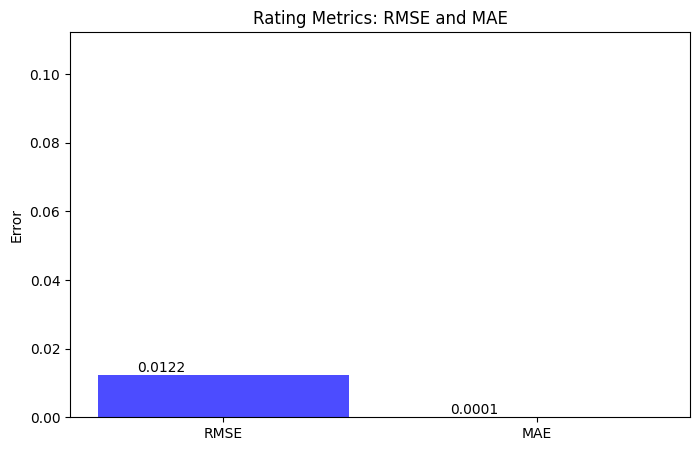

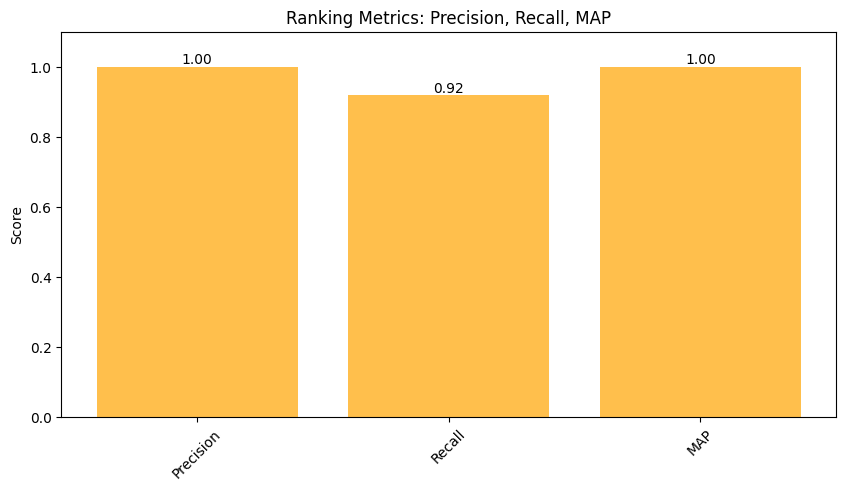

In [ ]:
import matplotlib.pyplot as plt

# Rating Metrics (RMSE, MAE)
rating_metrics = {'RMSE': final_test_rmse, 'MAE': test_mae}

# Plot Rating Metrics
plt.figure(figsize=(8, 5))
bars = plt.bar(rating_metrics.keys(), rating_metrics.values(), color=['blue', 'green'], alpha=0.7)
plt.title('Rating Metrics: RMSE and MAE')
plt.ylabel('Error')
plt.ylim(0, max(rating_metrics.values()) + 0.1)  # Penyesuaian skala y

# Tambahkan nilai di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.show()

# Ranking Metrics (Precision, Recall, MAP)
ranking_metrics = {
    'Precision': test_precision,
    'Recall': test_recall,
    'MAP': test_map,
}

# Plot Ranking Metrics
labels = ['Precision', 'Recall', 'MAP']
values = [ranking_metrics[label] for label in labels]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='orange', alpha=0.7)
plt.title('Ranking Metrics: Precision, Recall, MAP')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Skala y antara 0 hingga 1.1 untuk margin
plt.xticks(rotation=45)

# Tambahkan nilai di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()


## Hasil Rekomendasi

In [ ]:
def get_recommendations(ID, train_matrix, approx_matrix, top_n=10):
    """
    Menghasilkan rekomendasi item untuk pengguna tertentu.
    """
    # Debugging: Cek apakah user_id ada di indeks matriks
    if ID not in train_matrix.index:
        print(f"User ID {ID} tidak ditemukan di train_matrix. Berikut indeks yang tersedia:")
        print(train_matrix.index[:10])  # Tampilkan beberapa ID untuk memeriksa format
        raise KeyError(f"User ID {ID} tidak ditemukan di train_matrix.")

    # Ambil indeks pengguna
    user_idx = train_matrix.index.get_loc(ID)

    # Ambil rating asli pengguna
    user_ratings = train_matrix.iloc[user_idx]

    # Ambil prediksi rating dari matriks rekonstruksi
    user_predictions = approx_matrix[user_idx]

    # Buat DataFrame dengan item_id dan prediksi
    item_ids = train_matrix.columns
    recommendations = pd.DataFrame({
        'item_id': item_ids,
        'predicted_rating': user_predictions
    })

    # Hapus item yang sudah dinilai oleh pengguna
    rated_items = user_ratings[user_ratings > 0].index
    recommendations = recommendations[~recommendations['item_id'].isin(rated_items)]

    # Urutkan berdasarkan prediksi tertinggi
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)

    # Ambil top-N rekomendasi
    return recommendations.head(top_n)

# Pastikan user_id ada dalam format string
data['user_id'] = data['user_id'].astype(str)

# Membuat matriks user-item
train_matrix = create_user_item_matrix(train_data)

# Contoh penggunaan
ID = '1.00003e+20'  # Gunakan ID yang sesuai dari data
top_n = 5  # Jumlah rekomendasi
try:
    recommendations = get_recommendations(ID, train_matrix, test_approx_matrix, top_n=top_n)
    print(f"Top {top_n} rekomendasi untuk pengguna {ID}:")
    print(recommendations)
except KeyError as e:
    print(e)

# top-10 pengguna
top_n = 10  # Jumlah rekomendasi
try:
    recommendations = get_recommendations(ID, train_matrix, test_approx_matrix, top_n=top_n)
    print(f"Top {top_n} rekomendasi untuk pengguna {ID}:")
    print(recommendations)
except KeyError as a:
    print(a)


Top 5 rekomendasi untuk pengguna 1.00003e+20:
   item_id  predicted_rating
66      70          4.998892
9       16          0.074383
25      32          0.001131
21      29          0.000422
26      33          0.000191
Top 10 rekomendasi untuk pengguna 1.00003e+20:
   item_id  predicted_rating
66      70          4.998892
9       16          0.074383
25      32          0.001131
21      29          0.000422
26      33          0.000191
38      44          0.000185
42      48          0.000154
7       13          0.000152
32      39          0.000134
87       9          0.000120


In [ ]:
# Fungsi untuk menghitung Precision@N
def precision_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    relevant_recommended_items = set(recommended_items_at_k).intersection(relevant_items)
    return len(relevant_recommended_items) / k if k != 0 else 0

# Fungsi untuk menghitung Recall@N
def recall_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    relevant_recommended_items = set(recommended_items_at_k).intersection(relevant_items)
    return len(relevant_recommended_items) / len(relevant_items) if len(relevant_items) != 0 else 0

# Fungsi untuk menghitung MAP@N
def mean_average_precision_at_k(recommended_items_list, relevant_items_list, k):
    avg_precision = 0
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        avg_precision += precision_at_k(recommended_items, relevant_items, k)
    return avg_precision / len(recommended_items_list) if len(recommended_items_list) != 0 else 0

# Fungsi untuk menghitung RMSE dan MAE
def compute_rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

def compute_mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)


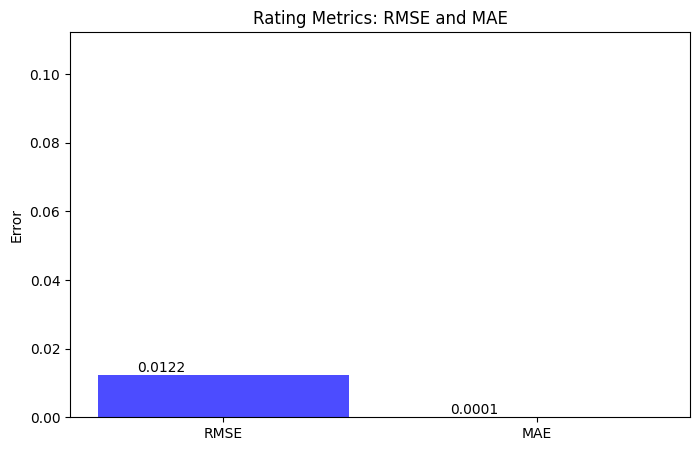

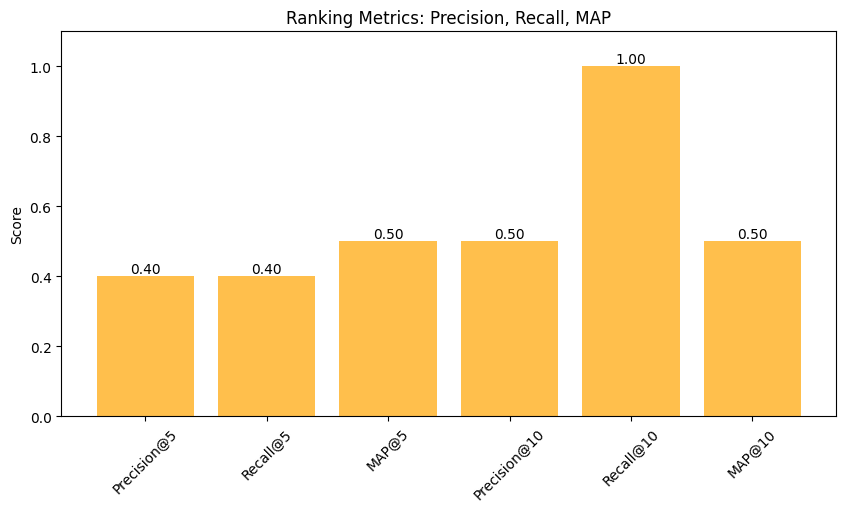

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Anggap Anda memiliki data prediksi dan relevansi
recommended_items = [['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7', 'item_8', 'item_9', 'item_10'],
                     ['item_2', 'item_1', 'item_6', 'item_3', 'item_4', 'item_8', 'item_7', 'item_5', 'item_9', 'item_10']]
relevant_items = [['item_1', 'item_3', 'item_6', 'item_8', 'item_9'],
                  ['item_1', 'item_2', 'item_6', 'item_5', 'item_9']]

# Precision@5, Recall@5, MAP@5, Precision@10, Recall@10, MAP@10
precision_5 = precision_at_k(recommended_items[0], relevant_items[0], 5)
recall_5 = recall_at_k(recommended_items[0], relevant_items[0], 5)
map_5 = mean_average_precision_at_k(recommended_items, relevant_items, 5)

precision_10 = precision_at_k(recommended_items[0], relevant_items[0], 10)
recall_10 = recall_at_k(recommended_items[0], relevant_items[0], 10)
map_10 = mean_average_precision_at_k(recommended_items, relevant_items, 10)

# Ranking Metrics
ranking_metrics = {
    'Precision@5': precision_5,
    'Recall@5': recall_5,
    'MAP@5': map_5,
    'Precision@10': precision_10,
    'Recall@10': recall_10,
    'MAP@10': map_10
}

# Rating Metrics (RMSE, MAE)
rating_metrics = {'RMSE': final_test_rmse, 'MAE': test_mae}

# Plot Rating Metrics (RMSE, MAE)
plt.figure(figsize=(8, 5))
bars = plt.bar(rating_metrics.keys(), rating_metrics.values(), color=['blue', 'green'], alpha=0.7)
plt.title('Rating Metrics: RMSE and MAE')
plt.ylabel('Error')
plt.ylim(0, max(rating_metrics.values()) + 0.1)  # Penyesuaian skala y

# Tambahkan nilai di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.show()

# Plot Ranking Metrics (Precision, Recall, MAP)
labels = list(ranking_metrics.keys())
values = list(ranking_metrics.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='orange', alpha=0.7)
plt.title('Ranking Metrics: Precision, Recall, MAP')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Skala y antara 0 hingga 1.1 untuk margin
plt.xticks(rotation=45)

# Tambahkan nilai di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

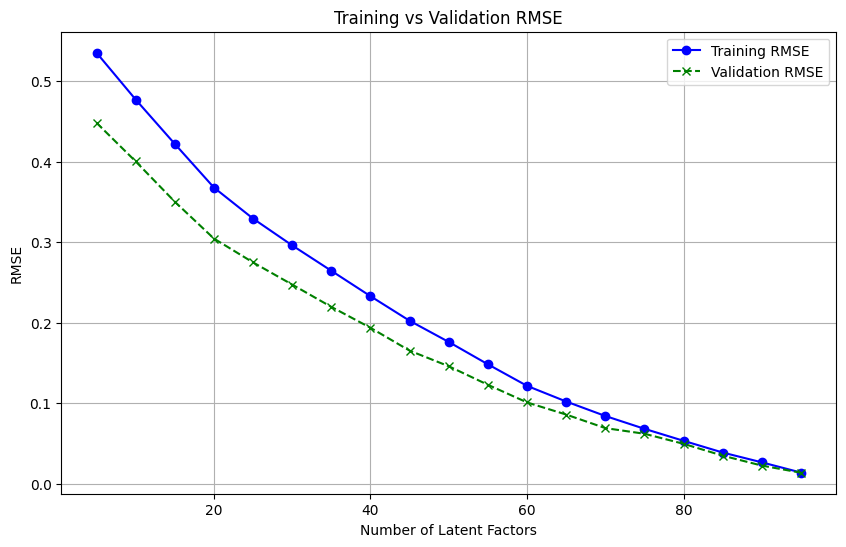

Optimal Latent Factors: 95


In [ ]:
# Generate RMSE for training and validation across latent factors
train_errors, val_errors = [], []
factors_range = range(5, min(101, train_matrix.shape[1] + 1), 5)  # Dynamic range of latent factors

# Ensure that both errors lists have the same size as factors_range:
train_errors = [0] * len(factors_range)
val_errors = [0] * len(factors_range)

for i, n_factors in enumerate(factors_range):
    svd = TruncatedSVD(n_components=n_factors, random_state=42)
    U_train = svd.fit_transform(train_matrix)
    Sigma = svd.components_

    # RMSE for training
    train_approx = np.dot(U_train, Sigma)
    train_errors[i] = compute_rmse(train_matrix.values, train_approx)  # Update errors list at correct index

    # RMSE for validation
    U_val = np.dot(val_matrix.values, Sigma.T)
    val_approx = np.dot(U_val, Sigma)
    val_errors[i] = compute_rmse(val_matrix.values, val_approx)  # Update errors list at correct index

# The rest of the code remains the same ...
# Plot RMSE to demonstrate overfitting (with patterns and colors for accessibility)
plt.figure(figsize=(10, 6))
plt.plot(factors_range, train_errors, label="Training RMSE", linestyle='-', marker='o', color='blue')
plt.plot(factors_range, val_errors, label="Validation RMSE", linestyle='--', marker='x', color='green')

plt.title("Training vs Validation RMSE")
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()

# Identify the optimal number of latent factors
optimal_factors = factors_range[val_errors.index(min(val_errors))]
print(f"Optimal Latent Factors: {optimal_factors}")


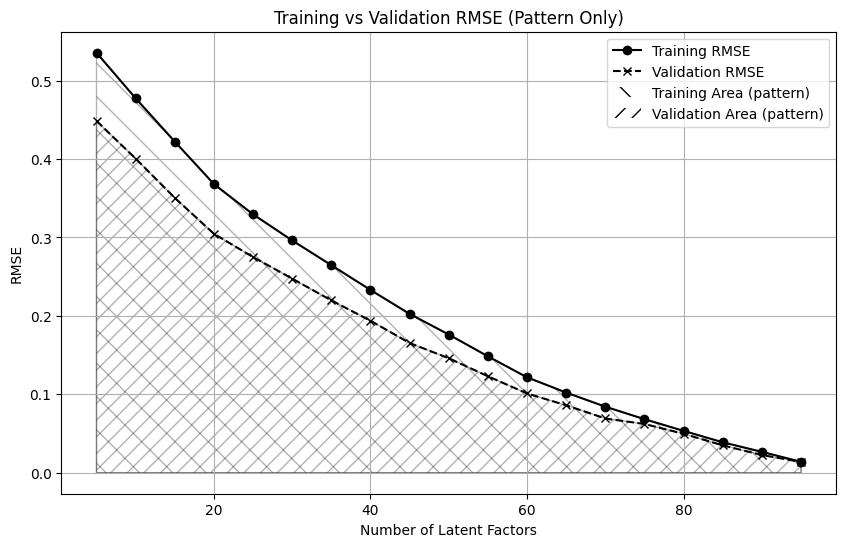

In [ ]:
# Plot RMSE with patterns only (no color, for colorblind readers)
plt.figure(figsize=(10, 6))
plt.plot(factors_range, train_errors, label="Training RMSE", linestyle='-', marker='o', color='black')
plt.plot(factors_range, val_errors, label="Validation RMSE", linestyle='--', marker='x', color='black')

# Add pattern differentiation without relying on color
plt.fill_between(factors_range, train_errors, alpha=0.3, label="Training Area (pattern)", facecolor='none', hatch='\\')
plt.fill_between(factors_range, val_errors, alpha=0.3, label="Validation Area (pattern)", facecolor='none', hatch='//')

plt.title("Training vs Validation RMSE (Pattern Only)")
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()
